#**Emojifier!**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_to_project = '/content/drive/MyDrive/PROJECTS/Emojifier/'
import sys    
sys.path.append(path_to_project)

Mounted at /content/drive


In [ ]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 8.7 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=04f38c9f3523c7214f4aa769fa640b254dc5734671a5955827279f9d675f93d2
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
# Importing required modules

import numpy as np
from emojifier_utilities import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

## 1 - Emojifier using Word Embeddings

Training dataset (X, Y) where:
- X contains sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

<img src="https://drive.google.com/uc?id=1TFLR8I6pFuamI1epx4VK1gWSvXNSSUVU" width="700px" height = "300px">

Similar to training dataset, testing dataset (X, Y) consists of sentences and their corresponding emojis.

In [ ]:
# Getting training and testing dataset

X_train, Y_train = read_csv(path_to_project + 'data/training_dataset.csv')
X_test, Y_test = read_csv(path_to_project + 'data/testing_dataset.csv')

In [ ]:
# Getting maximum length of training dataset sentences

maxLen = len(max(X_train, key=len).split())
print(maxLen)

10


In [ ]:
# Printing top few training dataset examples 

num = 5
for idx in range(num):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴


In [ ]:
# Converting the labels for both testing and training dataset to one-hot vector representations,
# so that they can be provided as input to softmax layer

Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

# An example of one-hot vector representation

idx = 100
print(f"Sentence '{X_train[idx]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I love my dad' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


I will be using 50-dimensional GloVe vector embeddings to convert from word to its vector representation

- word_to_index: dictionary mapping from words to their indices in the vocabulary, currently there are 400,001 words, in the vocabulary

- index_to_word: dictionary mapping from indices to their corresponding words in the vocabulary

- word_to_vec_map: dictionary mapping words to their GloVe vector representation

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(path_to_project + 'data/glove.6B.50d.txt')

In [ ]:
word = "cucumber"
idx = 289846
print("The index of ", word, "in the vocabulary is : ", word_to_index[word])
print("The", str(idx) + " th word in the vocabulary is ", index_to_word[idx])

The index of  cucumber in the vocabulary is :  113317
The 289846 th word in the vocabulary is  potatos


In [ ]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    """

    any_word = list(word_to_vec_map.keys())[0]
    avg = word_to_vec_map[any_word].shape
    avg = np.zeros((avg))
    
    words = sentence.lower().split()
    count = 0
    
    for w in words:
        if w in list(word_to_vec_map.keys()):
            avg += word_to_vec_map[w]
            count = count + 1
          
    if count > 0:
        avg = avg / count
    
    return avg

<a name='1-1'></a>
### 1.1 - Implementing the Model i.e. Training Phase

Steps followed: 
* Pass the sentence average through forward propagation
* Compute the cost
* Backpropagate to update the parameters

In [ ]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train emojifier using word vector representations.
    """
    
    any_word = list(word_to_vec_map.keys())[0]
        
    cost = 0
    
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    Y_oh = convert_to_one_hot(Y, C = n_y)
    
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            avg = sentence_to_avg(X[i], word_to_vec_map)

            z = np.dot(W, avg) + b
            a = softmax(z)

            cost = -1 * np.sum(Y_oh[i] * np.log(a))
            
            # Computing the gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)             # predict is defined in emo_utils.py
                                                                    # it is used to calculate the accuracy of the model and return the predictions
                                                                    

    return pred, W, b   # pred - vector of predictions, numpy-array of shape (m, 1)
                        # W - weight matrix of the softmax layer, of shape (n_y, n_h)
                        # b - bias of the softmax layer, of shape (n_y,)

In [ ]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.9520498812810076
Accuracy: 0.3484848484848485
Epoch: 100 --- cost = 0.07971818726014794
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.04456369243681402
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = 0.03432267378786059
Accuracy: 0.9696969696969697
[[3.]
 [2.]
 [3.]
 [0.]
 [4.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [4.]
 [3.]
 [3.]
 [4.]
 [0.]
 [3.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [0.]
 [3.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [4.]
 [1.]
 [2.]
 [1.]
 [1.]
 [3.]
 [1.]

<a name='1-2'></a>
### 1.2 - Testing the Model i.e. Testing Phase

In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


<a name='1-3'></a>
### 1.3 - Try on some user provided dataset

In [ ]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


<a name='1-4'></a>
### 1.4 - Confusion Matrix of Emojifier using word embeddings

(56,)
           ❤️   ⚾   😄   😞  🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


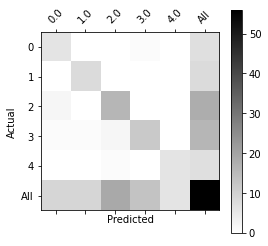

In [ ]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '   ' + label_to_emoji(1) + '   ' +  label_to_emoji(2)+ '   ' + label_to_emoji(3)+'  ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

<a name='2'></a>
## 2 - Emojifier: Using LSTMs in Keras 


In [ ]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

In [ ]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    """
    
    m = X.shape[0]      # number of training examples
    
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
        
        sentence_words = X[i].lower().split()
        j = 0
        
        for w in sentence_words:
            if w in list(word_to_index.keys()):
                X_indices[i, j] = word_to_index[w]
                j =  j+1
            
    return X_indices

In [ ]:
# Just giving examples on how above function will work.

X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 for representing unknown word
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]
      
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_size, emb_dim, trainable=False)
    
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [ ]:
# Embedding layer set properties

embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


<a name='2-1'></a>
### 2.1 - Implementing the Model

In [ ]:
def Emojifier(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojifier model.
    """
    
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    
    X = LSTM(units=128, return_sequences=True)(embeddings)
    
    X = Dropout(rate=0.5)(X)
    
    X = LSTM(units=128, return_sequences=False)(X)  # Here 'return_sequences' will decide, whether we want to
                                                    # return every hidden states or only the last one.
    
    X = Dropout(rate=0.5)(X)
    
    X = Dense(units=5)(X)
    
    X = Activation('softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [ ]:
model = Emojifier((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 10, 50)            20000050  
                                                                 
 lstm (LSTM)                 (None, 10, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645   

<a name='2-2'></a>
### 2.2 - Compiling the Model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<a name='2-3'></a>
### 2.3 - Training the Model 

In [ ]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 4s 26ms/step - loss: 1.5977 - accuracy: 0.2576
Epoch 2/50
5/5 [==============================] - 0s 26ms/step - loss: 1.5067 - accuracy: 0.3485
Epoch 3/50
5/5 [==============================] - 0s 25ms/step - loss: 1.4918 - accuracy: 0.3106
Epoch 4/50
5/5 [==============================] - 0s 25ms/step - loss: 1.4001 - accuracy: 0.3788
Epoch 5/50
5/5 [==============================] - 0s 27ms/step - loss: 1.2800 - accuracy: 0.5000
Epoch 6/50
5/5 [==============================] - 0s 27ms/step - loss: 1.2160 - accuracy: 0.5227
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 1.1286 - accuracy: 0.5833
Epoch 8/50
5/5 [==============================] - 0s 23ms/step - loss: 1.0100 - accuracy: 0.6061
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 0.8190 - accuracy: 0.7121
Epoch 10/50
5/5 [==============================] - 0s 23ms/step - loss: 0.7777 - accuracy: 0.6970
Epoch 11/50
5/5 [============

<a name='2-4'></a>
### 2.4 - Evaluating the Model 

In [ ]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 1s 13ms/step - loss: 0.4752 - accuracy: 0.8750

Test accuracy =  0.875


In [ ]:
# This code will show mislabelled predictions by our model

C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😞 prediction: work is horrible	😄
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😞 prediction: My life is so boring	❤️
Expected emoji:😞 prediction: go away	⚾
Expected emoji:🍴 prediction: I did not have breakfast ❤️


<a name='2-5'></a>
### 2.5 - Running Emojifier on our own input

In [ ]:
given_sentence = 'not feeling happy'     # Change this sentence

x_test = np.array([given_sentence])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

not feeling happy 😞
